# 1.2: Feature Attribution for Language Models — Approaches and Evaluation
*Assignment created by **Jaap Jumelet**, with additional help from **Tom Kersten** and **Jelle Zuidema**. Part of the UvA AI MSc course Interpretability & Explainability in AI, June 2022. Updated to fit within one werkcollege by **Maria Heuss** (June 2024).*

## When to start working on this lab
Even though there will be a lab session where you can work on completing this notebook and the report we recommend having a look at the notebook and giving it a try before your lab session. That way you can make sure that you are getting the most out of the lab by asking some focused questions. Note that for this report the will be on Friday evening already. Please do not start working on the assignment in your lab session on Friday, especially if it is one of the later ones. 

### Introduction
In this assignment you will gain a better understanding of Feature Attribution methods. Feature Attribution methods explain the prediction of a model as a sum of contributions from the input features. For example, if we were to be explaining the output of a language model (that assigns a probability to the next token) on the input "*The athletes above Barbara ...", the output of "*walk*" could be explained as the following sum of contributions:

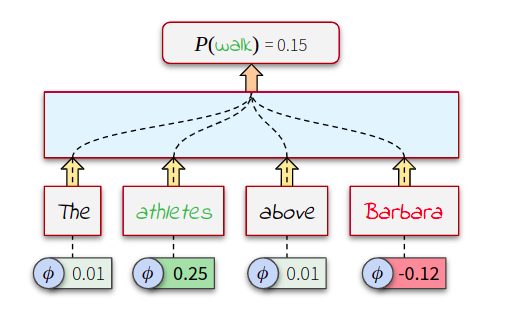

A lot of attribution methods have been proposed over the passed few years. You may have heard of some of them, like LIME, SHAP, Integrated Gradients, or GradCAM. Each of these methods have their own strengths and weaknesses, but has become increasingly harder to make sense of which method is truly the most **faithful** to the actual behaviour of the underlying model. This is a notoriously hard problem, because we don't have access to the "*gold explanation*" of model behaviour: it is, after all, precisely this gold explanation that we are trying to obtain via our feature attribution methods.

## Assignment
In our assignment we will focus on a small subset of attribution methods, and compare these. We will look into methods that aim to evaluate and quantify the faithfulness of an attribution method. You will use these methods to conduct a small-scale qualitative analysis on a **sentiment classification** model. After all, attribution methods should provide us a better insight into the reasoning of a model, so ideally an attribution will give us a better, more qualitative insight into its behaviour.

## Models and Data

For your experiments, you will make use of the RoBERTa model ([Liu et al. 2019 ](https://arxiv.org/abs/1907.11692)). RoBERTa, as you may recall, is an extension of BERT for which the pretraining procedure has been changed. Importantly, RoBERTa has been trained on more data, with longer sequences. However, it removed the next sentence prediction objective.

We will evaluate our model using the Stanford Sentiment Treebank (or [SST2](https://arxiv.org/abs/1804.07461)) dataset. The dataset consists out of 11,855 movie reviews, each annotated with sentiment. This kind of data is ideal for attribution extraction, as sentiment often contains very clear words which mark the sentiment for that sentence.

**N.B.: Before you run this cell make sure GPU support is enabled! Some of the methods we will be using are quite compute-heavy.**

In [ ]:
!pip install transformers datasets captum

import transformers
import torch
import os
import numpy as np
import pandas as pd
from typing import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def load_model(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path)
    model.eval()
    model.to(DEVICE)

    return model, tokenizer


# We use a fine-tuned roberta model in our experiments
model, tokenizer = load_model("textattack/roberta-base-SST-2")

For the sentiment classification task we will make use of Huggingface's `datasets` library, which makes it very easy to load in SST2 and do post-processing on it.

In [ ]:
from datasets import load_dataset


# We can directly load in the SST2 dataset
dataset = load_dataset("gpt3mix/sst2")


# We still need to encode the raw sentences based on the tokenizer we're using
def encode(batch):
    encoded = tokenizer(
        batch["text"],
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    ).to(DEVICE)

    # Invert labels (0 <> 1), because it's the other way around somehow for roberta
    batch['label'] = (~torch.tensor(batch['label']).bool()).long()
    batch['text'] = [
        tokenizer.tokenize(sen, add_special_tokens=True)
        for sen in batch['text']
    ]

    return {**encoded, **batch}


def detokenize(tokens, single_string=True):
    """
    Convert tokenized text back to a human-readable format. We will use this
    function to make our examples easier to read.

    Args:
    tokens (list of str): The tokenized text.

    Returns:
    str: The detokenized, human-readable text.

    """
    if not single_string:
      return [token.replace('Ġ', ' ') if token not in ['<s>', '</s>'] else token for token in tokens ]
    return ''.join(token.replace('Ġ', ' ') for token in tokens if token not in ['<s>', '</s>']).strip()



dataset.set_transform(encode)

<font color='green'><b>ToDo 1</b></font>

Inspect the data you have been given. Make sure you understand what the data looks like, and what the labels mean. Iterate over your data, and see what happens if you try to access a single item in the corpus, or multiple at once.

In [ ]:
for attr, value in dataset['train'][:2].items():
    print(f"{attr:<15}", value)

Now that you have inspected the data, let us try to use it alongside the loaded model.

<font color='green'><b>ToDo 2</b></font>

*   Produce a prediction using the model for the first sentence in the dataset in the test set. What sentiment is being predicted? Does this agree with the actual sentiment label?
*   List the first 5 sentences from the test set for which the model produces **incorrect** predictions (in the test set).

<font color='red'><b>ToSubmit 1</b></font>
The list of 5 sentences you have found on which the model makes an incorrect prediction. Add a brief caption to the listing in which you state some patterns that you observe (max 50 words).

In [ ]:
# Function to make predictions
def predict(data_point):
    input_ids = data_point['input_ids'].unsqueeze(0).to(DEVICE)
    attention_mask = data_point['attention_mask'].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    return predicted_class, probabilities

In [ ]:
# Your code here (list 5 sentences with incorrect predictions)

## Attribution Methods

For this workshop, you will look at several existing attribution methods, see how they work and compare and contrast their similarities and differences. For your experiments, you will consider the following attribution methods:

* Feature Ablation
* Shapley Values
* Integrated Gradients
* KernelShap

To make sure these four methods are compatible with subsequent evaluation procedures, we will let each instantiation inherit from an abstract `FeatureAttributor` class. Note that this class also contains a method to retrieve the model logits, which may be of use in your implementation of the attribution methods. We will generate explanations based on the change of logits, rather than the change in class probability.

You can use the `visualize_attribution` method to visualize the attributions for a particular method.

In [ ]:
from abc import abstractmethod

from captum.attr import visualization
from IPython.display import display, HTML


class FeatureAttributor:
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
        **kwargs
    ) -> torch.Tensor:
        """
        Computes the attributions for a single input.

        Parameters
        ----------
        input_ids : torch.Tensor
            shape: (batch_size, sen_len)
        baseline_ids : torch.Tensor
            shape: (batch_size, sen_len)
        target : int
            Output class that is being explained

        Returns
        -------
        attributions : torch.Tensor
            shape: (sen_len,)
        """
        pass

    def logits(self, input_ids, target=None):
        squeeze_output = input_ids.ndim == 1
        if squeeze_output:
            input_ids = input_ids.unsqueeze(0)

        with torch.no_grad():
            if target is None:
              logits = self.model(input_ids).logits
            else:
              logits = self.model(input_ids).logits[:, target]

        if squeeze_output:
            logits = logits.squeeze()

        return logits


def visualize_attribution(sen: List[str], attributions: torch.Tensor, normalize: bool = True, human_readable = True):
    attributions = attributions.squeeze()

    if normalize:
        attributions /= torch.max(attributions.abs())

    if human_readable:
        sen = detokenize(sen, single_string=False)

    raw_html = visualization.format_word_importances(
        sen, attributions
    )
    html = HTML(raw_html)
    display(html)

### Feature Ablation

Feature Ablation ([Li, Monroe and Jurafsky, 2016](https://arxiv.org/abs/1612.08220)) is a simple attribution method. We replace individiual tokens in the sentence with some baseline token, and measure the difference in output between the original sentence and the modified one. We then assign the resulting difference to the replaced token. This procedure is summarised in the following formula, where $a_{i}$ is the attribution score for the token at position $i$, $\mathcal{M}$ is the model and $\mathcal{F}_{i}$ is the replacement method at position $i$.

$$a_{i}(x) = \mathcal{M}(x) - \mathcal{M}(\mathcal{F}_i(x))$$

<font color='blue'><b>ToThink 1</b></font> Consider how we may model the exclusion of one or multiple tokens from our input. Do you completely remove the feature? Replace it with a default token? Or sample it from a distribution? What impact do these choices have on your explanations?

<font color='green'><b>ToDo 3</b></font>
Implement the ablation attribution method below. You can test your method on the example sentence that has been provided.

In [ ]:
class AblationAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        # Your code for computing feature ablation
        raise NotImplementedError


sen = "I wish I liked it more, although I did not dislike it"
item = {
    "input_ids": tokenizer(sen, return_tensors='pt').to(DEVICE)['input_ids'].squeeze(),
    "text": tokenizer.tokenize(sen, add_special_tokens=True),
    "label": torch.tensor(1),
}
input_ids = item['input_ids']
sen_len = len(item['text'])

baseline_id = tokenizer.unk_token_id  # Set the baseline to the <unk> toke
baseline_ids = torch.tensor([baseline_id] * sen_len, device=DEVICE)
label = item['label'].item()

ablation_attributor = AblationAttributor(model)
ablation_attributions = ablation_attributor.attribute(input_ids, baseline_ids, label)

for w, phi in zip(detokenize(item['text'], single_string=False), ablation_attributions):
    print(f"{w:<15} {phi.item():.3f}")

visualize_attribution(item['text'], ablation_attributions)
print(ablation_attributor.logits(input_ids))


### Shapley Values

Another approach to assigning attribution scores comes from game theory. Shapley values ([Shapley, 1951](https://www.rand.org/pubs/research_memoranda/RM0670.html)) provide a framework for the assignment of contributions to players in a team. More specifically, we can estimate the contributions of a player by comparing the results of all coalitions including our player to those same coalitions without our player. These differences indicate the contributions of our player towards the game, and can be considered their attribution. The mathematical formulation for this procedure is as follows:

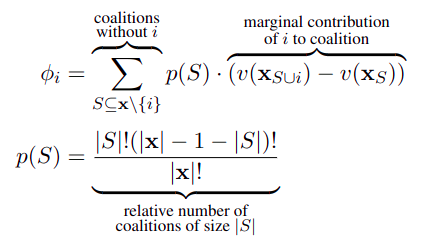

We can translate this concept to NLP by considering the team to be the input to the model. As such the players in our imaginary game have become the tokens in the input. We can evaluate the performance by looking at all possible coalitions (i.e. subsets) of our input with respect to a single token, either including or excluding it.

<font color='blue'><b>ToThink 2</b></font> How does the computation of a Shapley values scale, in terms of the number of input features?

<font color='green'><b>ToDo 4</b></font>
Fill in the missing part in `ShapleyAttributor.attribute` below. The model outputs have been pre-computed (`coalition_logits`), so all that is left to do is to finish the Shapley computation steps as outlined in the mathematical formulation above.

In [ ]:
from itertools import chain, combinations
from math import factorial
from tqdm import notebook


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))


def coalitions_without_i(sen_len, i):
    features_not_i = [j for j in range(sen_len) if j != i]
    for coalition in powerset(features_not_i):
        yield coalition


class ShapleyAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        sen_len = input_ids.shape[-1]

        coalition_logits, coalition_to_index = self.compute_coalition_logits(
            input_ids, baseline_ids, target
        )

        shapley_values = torch.zeros(sen_len)

        for i in range(sen_len):
            for S in coalitions_without_i(sen_len, i):
                S_i = tuple(sorted(S + (i,)))
                index_S = coalition_to_index[S]
                index_S_i = coalition_to_index[S_i]

                # Your code for computing the Shapley value
                # Note you can use the index_S(_i) values to index the coalition_logits
                raise NotImplementedError

        return shapley_values

    def compute_coalition_logits(self, input_ids, baseline_ids, target):
        """
        Computes the model output for all possible coalitions, in batches.

        Returns
        -------
        coalition_logits : torch.Tensor
            shape: (2**sen_len,)
            The output logit for each coalition
        coalition_to_index : Dict[Tuple[int], int]
            Dictionary mapping a coalition tuple to its index in the
            coalition_logits tensor.
        """
        sen_len = input_ids.shape[-1]
        num_coalitions = 2**sen_len

        coalitions = torch.zeros(num_coalitions, sen_len, dtype=torch.long).to(DEVICE)
        coalitions += baseline_ids  # set baseline as default

        coalition_to_index = {}

        for idx, coalition in enumerate(powerset(range(sen_len))):
            coalition_to_index[coalition] = idx
            if len(coalition) > 0:
                coalition = list(coalition)
                coalitions[idx, coalition] = input_ids[coalition]

        coalition_logits = torch.zeros(num_coalitions)
        batch_size = 1024
        batch_iterator = torch.split(coalitions, batch_size)
        for batch_idx, batch in notebook.tqdm(
            enumerate(batch_iterator), total=len(batch_iterator)
        ):
            with torch.no_grad():
                batch_logits = self.logits(batch, label)
            coalition_logits[
                batch_idx * batch_size : (batch_idx + 1) * batch_size
            ] = batch_logits

        return coalition_logits, coalition_to_index


shapley_attributor = ShapleyAttributor(model)
shapley_attributions = shapley_attributor.attribute(input_ids, baseline_id, label)

visualize_attribution(item["text"], shapley_attributions)


### KernelSHAP

Directly computing Shapley values is an expensive process, as it scales exponentially with the size of the input. Because of this, computing Shapley values for larger inputs becomes infeasible, especially over larger datasets. As such, approximations are needed to compute these values.

KernelSHAP ([Lundberg and Lee, 2017](https://arxiv.org/abs/1705.07874)) is one such approximation. It seeks to reduce the complexity to a managable scale by using a different approach called LIME ([Ribeiro, Singh, and Guestrin, 2016](https://arxiv.org/abs/1602.04938)). LIME seeks to produce a linear approximation of a model, and inspect this surrogate model. It trains a linear model on a simplified input, noting the presence or absence of individual training features, which produces a model which is able to mimic the original model. However, for this process a loss function, weighing kernel and a regularization term are needed. In Lunderberg and Lee (2017), they show that by carefully choosing these parameters, the regression coefficients of the model resemble the Shapley values corresponding to these.

<font color='green'><b>ToDo 5</b></font>
Fill in the missing part in `ShapAttributor.attribute` below. You can make use of the `captum` implementation of KernelSHAP (check out the API [here](https://captum.ai/api/kernel_shap.html)). Experiment with the number of coalitions that are being sampled (n_samples) and make sure the estimation is fairly stable.


In [ ]:
from captum.attr import KernelShap



class ShapAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        input_ids = input_ids.unsqueeze(0)
        baseline_ids = baseline_ids.unsqueeze(0)
        ks = KernelShap(self.logits)

        # Your code here
        raise NotImplementedError

shap_attributor = ShapAttributor(model)
shap_attributions = shap_attributor.attribute(input_ids, baseline_ids, label)
visualize_attribution(item['text'], shap_attributions)

### Integrated Gradients

Integrated Gradients ([Sundararajan, Taly, and Yan, 2017](https://arxiv.org/abs/1703.01365)) seeks to assign attributions through measuring differences in output of a model as the input space changes. More specifically, we are looking to measure gradients along the path from some baseline input to our original input. In this way, Integrated Gradients performs Saliency Mapping at multiple points along the straightline path from a baseline input $x^\prime$ to the original input $x$. This operation is mathematically defined as:

$$ a_{i}(x)=\left(x_{i}-x_{i}^{\prime}\right) \times \int_{\alpha=0}^{1} \frac{\partial F\left(x^{\prime}+\alpha \times\left(x-x^{\prime}\right)\right)}{\partial x_{i}} d \alpha$$

As you can read in the original paper of IG, this path integral actually approximates a quantity from game theory as well, the Aumann-Shapley value, which can roughly be understood as the extension of the (discrete) Shapley value to the case in which the players are continuous. Fairly vague and hard to wrap your head around, so don't worry to much about it 😃.

<font color='green'><b>ToDo 6</b></font>
Fill in the missing part in `IGAttributor.attribute` below. You can make use of the `captum` implementation of Integrated Gradients. Make sure to have a look at the documentation of their implementation here: https://captum.ai/api/integrated_gradients.html

Important to keep in mind is that Integrated Gradients operate on the embedding space, and as such the method expects the input to be the word embeddings, and not the input ids. You can access the word embeddings of RoBERTa as follows: `model.roberta.embeddings.word_embeddings(..)` To get back to token-level attributes, we take the sum of the attribution values over the dimensions of the embedding for each individual token.


In [ ]:
from captum.attr import IntegratedGradients


def model_forward(inputs_embeds):
    return model(inputs_embeds=inputs_embeds).logits


class IGAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
        n_steps: int = 50,
    ) -> torch.Tensor:

        input_ids = input_ids.unsqueeze(0)
        baseline_ids = baseline_ids.unsqueeze(0)

        # Get the word embeddings for input and baseline

        # Use the model_forward from above for the initialization of IntegratedGradients

        # Determine attributions

        # Take the sum over the feature attributes for each individual token

        return ig_attributions.squeeze()





ig_attributor = IGAttributor(model)
ig_attributions = ig_attributor.attribute(input_ids, baseline_ids, label)

visualize_attribution(item['text'], ig_attributions)

## Evaluation

Evaluating attribution methods is still a topic of debate in the scientific community. Several methods exsist which look at different aspects of these methods to gauge how well they explain the behaviour of the model. For this workshop, we will focus on two such methods:

- Comprehensiveness
- Sufficiency

### Comprehensiveness
Comprehensiveness ([DeYoung et al., 2020](https://aclanthology.org/2020.acl-main.408/)) is the average difference of the change in predicated class probability before and after removing the top k% of tokens according to the used attribution method. In doing so, we shorten the original sentence by removing the designated tokens. It is expected that by removing the top tokens, the predicated class probability will lower as important information for the prediction of the model should be captured in the top tokens. It is defined as:

$$\operatorname{Comp}(k)=\frac{1}{N} \sum_{i=1}^{N} p(y^* \mid \boldsymbol{x}_{i}) - p(y^* \mid \boldsymbol{x}_{i}^{(k)}),$$

where $N$ is the number of input sentences, ${y^*}$ the target class, $x_i$ the $i$-th input sentence and $x_{i}^{(k)}$ the modified sentence with the top k% tokens removed.

### Sufficiency
Sufficiency ([DeYoung et al, 2020](https://aclanthology.org/2020.acl-main.408/)) is the average difference of the change in predicated class probability before and after keeping only the top k% of tokens according to the used attribution method. This method is very similar to Comprehensiveness, but flips the premise and seeks to identify how much information is captured in only the top k% of tokens. This score is defined similarly to Comprehensiveness, only changing $x_{i}^{(k)}$ to mean the modififed sentence with only the top k% tokens.


A common value for $k$ is $20\%$.

<font color='green'><b>ToDo 7</b></font>
Fill in the two methods for comprehensiveness, and sufficiency below.

<font color='green'><b>ToDo 8</b></font>
Compute the methods for the example sentence we have been using. You can compute the metrics with relation to the target label. Do you observe any differences between the methods?

<font color='blue'><b>ToThink</b></font>
What impact does a token like *not* have on the evaluation scores? Can attribution methods properly handle negation, which invokes a form of feature *interaction*?

In [ ]:
def comprehensiveness(model, attributions, input_ids, target, k=0.2):
    raise NotImplementedError

def sufficiency(model, attributions, input_ids, target, k=0.2):
    raise NotImplementedError


evaluate = sufficiency
sen_len = len(input_ids)

for name, attributions in [
    ("ablation", ablation_attributions),
    ("shapley", shapley_attributions),
    ("ig", ig_attributions),
    ("shap", shap_attributions),
]:
    print(f"{name:<10} {evaluate(model, attributions, input_ids, label):.3f}")

We now have all the steps in place to evaluate our attribution methods on a corpus, and compute its faithfulness using the three methods we have defined in the previous step.

Because of the computational constraints of the exact Shapley Values, we will leave out this method here, and rely on the approximation provided by KernelSHAP.

<font color='red'><b>ToSubmit 2</b></font>
Create a table for the attribution evaluation scores with an attribution method on each row, and an evaluation method on each column. Your table will be 3x2: three attribution methods, and 2 evaluation methods. To save computation time you may opt to compute this table on a subset of the test set of the first 300 items. Write a brief caption that describes the general patterns that you observe here.


In [ ]:
from tqdm import notebook

def evaluate_corpus(corpus, attributor, attributor_name):
    all_attributions = []
    scores_df = pd.DataFrame(columns=["method", "comp", "suff"])

    for input_ids, attention_mask, label in notebook.tqdm(zip(
        corpus['input_ids'],
        corpus['attention_mask'],
        corpus['label']
    )):
        input_ids = input_ids[attention_mask.bool()]
        baseline_ids = torch.zeros_like(input_ids) + baseline_id

        attributions = attributor.attribute(input_ids, baseline_ids, label)

        comp_score = comprehensiveness(model, attributions, input_ids, label, k=0.3)
        suff_score = sufficiency(model, attributions, input_ids, label, k=0.3)

        entry = pd.Series(
            [attributor_name, comp_score, suff_score],
            index=scores_df.columns
        )
        scores_df.loc[len(scores_df)] = entry

        all_attributions.append(attributions)

    return all_attributions, scores_df


sample_size = 300
sample = dataset['test'][:sample_size]

ablation_attributions, ablation_df = evaluate_corpus(sample, ablation_attributor, "ablation")
ig_attributions, ig_df = evaluate_corpus(sample, ig_attributor, "ig")
shap_attributions, shap_df = evaluate_corpus(sample, shap_attributor, "shap")

combined_df = pd.concat([ablation_df, ig_df, shap_df])
combined_df.groupby("method").mean()

<font color="red"><b>ToSubmit 3</b></font>
Using the attributions you have computed, perform a more in-depth analysis. You can focus on questions like:
- On what types of sentences do the attribution evaluation methods give *bad* scores?
- Are there sentences where one attribution method scores much better than the others?
- Related to the ToThink question of above: how do attribution methods with word interactions like negation (*not bad at all*) and adverbials (*incredibly bad*)? How do such interactions impact attribution evaluation methods?

Think of _a single hypothesis_ that you aim to address. The questions raised above may help you aid in formulating this hypothesis, but you can think of something yourself as well. The main goal here, on the one hand, is to use our attribution scores to obtain a better understanding of our model, yet on the other hand, to understand whether the evaluation methods are a valid way of measuring faithfulness. Your results can also be negative, meaning your hypothesis seems to be not supported.

For your report, submit the hypothesis that you are investigating, **one** sentence together with the feature attributions and a 1-3 sentence discussion on whether the hypothesis is supported by the qualitative example and why.
